In [10]:
import numpy as np

### init random seeds
rd_seed = 13246
np.random.seed(rd_seed)

from sklearn.pipeline import Pipeline
from pinard import preprocessor as pp

### Declare preprocessing pipeline components
preprocessing = [   ('id', pp.IdentityTransformer()),
                    ('savgol', pp.SavitzkyGolay()),
                    ('derivate', pp.Derivate()), 
                    # ('gaussian1', pp.Gaussian(order = 1, sigma = 2)),
                    # ('gaussian2', pp.Gaussian(order = 2, sigma = 1)),
                    ('haar', pp.Wavelet('haar')),
                    ('savgol*savgol', Pipeline([('_sg1',pp.SavitzkyGolay()),('_sg2',pp.SavitzkyGolay())])),
                    # ('gaussian1*savgol', Pipeline([('_g1',pp.Gaussian(order = 1, sigma = 2)),('_sg3',pp.SavitzkyGolay())])),
                    # ('gaussian2*savgol', Pipeline([('_g2',pp.Gaussian(order = 1, sigma = 2)),('_sg4',pp.SavitzkyGolay())])),
                    # ('haar*savgol', Pipeline([('_haar2',pp.Wavelet('haar')),('_sg5',pp.SavitzkyGolay())]))
                ]

In [25]:
from pinard import nirs_set as n_set

### Load data
n = n_set.NIRS_Set('data')
X, y = n.load('Xcal.csv', 'Ycal.csv', x_hdr=0, y_hdr=0, y_cols=0)
X = X[:,1350:1450]
print(X.shape, y.shape)

(361, 100) (361,)


In [12]:
## Simple xgboost pipeline
from xgboost import XGBRegressor
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score

# xgb =  XGBRegressor()
# pipeline = Pipeline([
#     ('scaler', MinMaxScaler()), 
#     ('preprocessing', FeatureUnion(preprocessing)), 
#     ('XGB', xgb)
# ])

# estimator = TransformedTargetRegressor(regressor = pipeline, transformer = MinMaxScaler())

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = rd_seed)
# estimator.fit(X_train, y_train)
# Y_preds = estimator.predict(X_test)
# print("MAE", mean_absolute_error(y_test, Y_preds))
# print("MSE", mean_squared_error(y_test, Y_preds))
# print("MAPE", mean_absolute_percentage_error(y_test, Y_preds))
# print("R²", r2_score(y_test, Y_preds))


In [26]:
from sklearn.cross_decomposition import PLSRegression

## Simple PLS pipeline
pipeline = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('preprocessing', FeatureUnion(preprocessing)), 
    ('pls', PLSRegression(n_components=10))
])

estimator = TransformedTargetRegressor(regressor = pipeline, transformer = MinMaxScaler())

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = rd_seed)
estimator.fit(X_train, y_train)
Y_preds = estimator.predict(X_test)
print("MAE", mean_absolute_error(y_test, Y_preds))
print("MSE", mean_squared_error(y_test, Y_preds))
print("MAPE", mean_absolute_percentage_error(y_test, Y_preds))
print("R²", r2_score(y_test, Y_preds))


MAE 1.5611191744939987
MSE 4.693558895685649
MAPE 0.0356246860985362
R² 0.595882445410102


In [ ]:
## KERAS Model
##TODO > remove keraswrapper for sciKeras wrapper

from pinard.nirs_pipelines import FeatureAugmentation

import tensorflow
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, SpatialDropout1D,BatchNormalization,Flatten, Dropout

tensorflow.random.set_seed(rd_seed)

def keras_model(optimizer = 'adam'):
    model = Sequential()
    model.add(SpatialDropout1D(0.08))
    model.add(Conv1D (filters=8, kernel_size=15, strides=5, activation='selu'))
    model.add(Dropout(0.2))
    model.add(Conv1D (filters=64, kernel_size=21, strides=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv1D (filters=32, kernel_size=5, strides=3, activation='elu'))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(16, activation='sigmoid'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss = 'mean_squared_error', optimizer = optimizer, metrics = ['mae', 'mse'])
    return model

pipeline = Pipeline([
    ('scaler', MinMaxScaler()), 
    ('preprocessing', FeatureAugmentation(preprocessing)), 
    ('KerasNN',  KerasRegressor(build_fn = keras_model, epochs=100, batch_size=300, verbose = 0))
])

estimator = TransformedTargetRegressor(regressor = pipeline, transformer = MinMaxScaler())

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = rd_seed)
estimator.fit(X_train, y_train)
Y_preds = estimator.predict(X_test)
print("MAE", mean_absolute_error(y_test, Y_preds))
print("MSE", mean_squared_error(y_test, Y_preds))
print("MAPE", mean_absolute_percentage_error(y_test, Y_preds))
print("R²", r2_score(y_test, Y_preds))

In [28]:
##Explainer

import shap

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
# import seaborn as sns # for correlation heatmap

# perm_importance = permutation_importance(xgb, X_test, y_test)
# sorted_idx = perm_importance.importances_mean.argsort()
# plt.barh(np.arrange(0,len(X_test[0],1))[sorted_idx], perm_importance.importances_mean[sorted_idx])
# plt.xlabel("Permutation Importance")

# explainer = shap.GradientExplainer(pipeline, X_train)

explainer = shap.Explainer(estimator.predict, X_train)
# print(X_test[0:20].shape)
shap_values = explainer(X_test[0:20])
# shap.summary_plot(shap_values, X_test[0:20], plot_type="bar")


Permutation explainer: 21it [00:47,  2.95s/it]                        


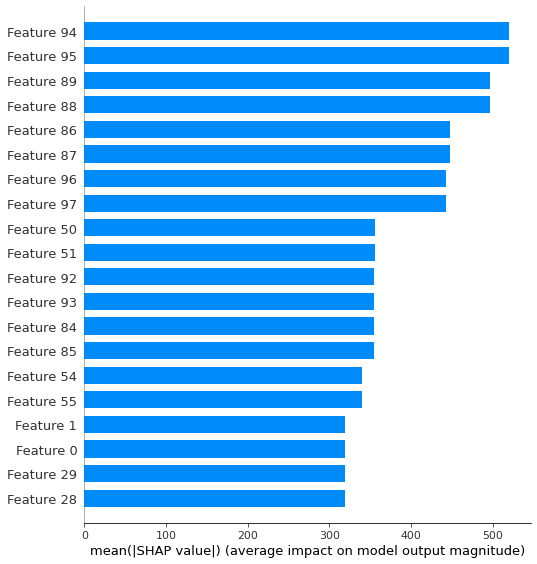

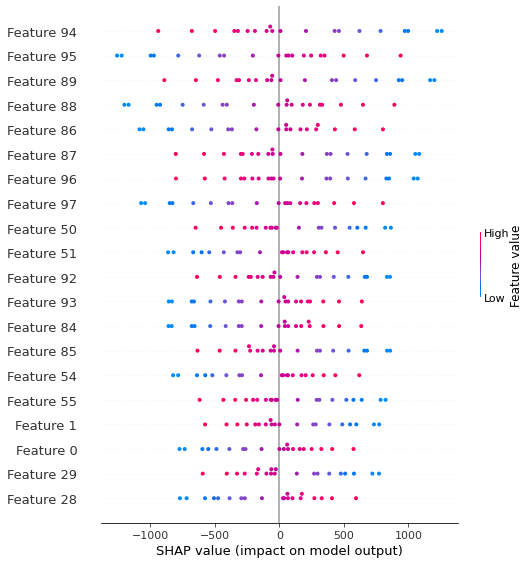

In [32]:
shap.summary_plot(shap_values, X_test, plot_type="bar")
shap.summary_plot(shap_values, X_test[0:20])


(20, 100)


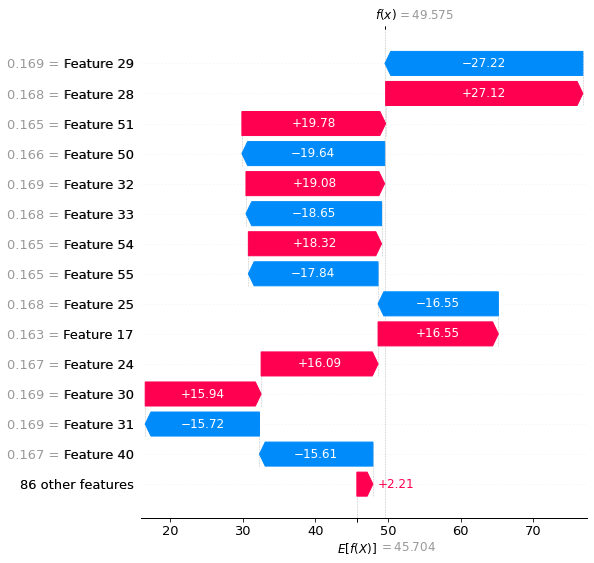

In [47]:
print(shap_values.shape)
shap.plots.waterfall(shap_values[1], max_display=100)